<a href="https://colab.research.google.com/github/NoobCoder-dweeb/AI-HandsOn-Journey/blob/main/notes/NSGA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From Scratch Implementation

In [10]:
import numpy as np
from copy import deepcopy
from itertools import chain
from typing import List, Tuple, Optional, Dict
from matplotlib import pyplot as plt

%matplotlib inline

In [11]:
# define parameters
generations = 100
population_size = 100
crossover_r = .7
mutation_r = .02
alpha = 0 # extend of exploration beyong parents genes
mu = .02

In [22]:
def dominates(A, B) -> bool:
  """Check if solution A dominates B"""
  return all(A["cost"] <= B["cost"]) and any (A["cost"] < B["cost"])

def non_dominated_sorting(population) -> Tuple[List[Dict[str, int]],List[List[int]]]:
  population_size = len(population)

  # initialise domination stats
  domination_set = [[] for _ in range(population_size)]
  dominated_count = [0 for _ in range(population_size)] # number of individuals that dominate individual i

  # init Pareto Fronts
  F = [[]]

  # find the pareto front
  for i in range(population_size):
    for j in range(i+1,population_size):
      # check if i dominates j
      if dominates(population[i], population[j]):
        domination_set[i].append(j)
        dominated_count[j] += 1
      # check if j dominates i
      elif dominates(population[j], population[i]):
        domination_set[j].append(i)
        dominated_count[i] += 1

    # if i is not dominated at all
    if dominated_count[i] == 0:
      population[i]['rank'] = 0
      F[0].append(i)

  # pareto counter to track paretor front being accessed
  k = 0

  while True:
    # init the next pareto front
    Q = []

    # find members of the next Pareto front
    for i in F[k]:
      for j in domination_set[i]:
        dominated_count[j] -= 1
        if dominated_count[j] == 0:
          population[j]["rank"] = k+1
          Q.append(j)

    if not Q:
      break

    # append the next pareto front
    F.append(Q)

    k+=1

  return population, F

def calc_crowding_distance(population, F) -> List[Dict[str, float]]:
  pareto_count = len(F)

  # number of objective functions
  n_obj = len(population[0]["cost"])

  # iterate over pareto fronts
  for k in range(pareto_count):
    costs = np.array([population[i]["cost"] for i in F[k]])
    n = len(F[k])
    d = np.zeros((n, n_obj))
    # iterate over objective
    for j in range(n_obj):
      idx = np.argsort(costs[:, j])
      d[idx[0], j] = np.inf
      d[idx[-1], j] = np.inf

      for i in range(1, n-1):
        d[idx[i], j] = costs[idx[i+1], j] - costs[idx[i-1], j]
        d[idx[i], j] /= costs[idx[-1], j] - costs[idx[0], j]

    # calculate crowding distance
    for i in range(n):
      population[F[k][i]]["crowding_distance"] = sum(d[i, :])

  return population

def sort_population(population):
  """Sorts a population based on rank (in asceding order) and crowding distance (in descending order)"""
  population = sorted(population, key = lambda x: (x["rank"], -x["crowding_distance"]))
  max_rank = population[-1]["rank"]
  F = []
  for r in range(max_rank + 1):
    F.append([i for i in range(len(population)) if population[i]["rank"]==r])

  return population, F

def truncate_population(population, F, population_size:Optional[int]=None):
  if population_size is None:
    population_size = len(population)
  if len(population) <= population_size:
    return population, F

  # truncate the population
  population = population[:population_size]
  # remove extra members from the pareto fronts
  for k in range(len(F)):
    F[k] = [i for i in F[k] if i < population_size]

  return population, F

def crossover(parent_1: np.array, parent_2: np.array):
  """Blend Crossover (BLX-α) """
  r_min = -alpha
  r_max = 1 + alpha
  r = np.random.uniform(r_min, r_max, parent_1.shape)
  child_1 = r*parent_1 + (1-r)*parent_2
  child_2 = r*parent_2 + (1-r)*parent_1
  return child_1, child_2

def mutate(x: np.array, sigma) -> np.array:
  n_var = x.size
  n_mu = np.ceil(mu * n_var)
  y = x.copy()

  J = np.random.choice(range(n_var), size=int(n_mu), replace=False)
  for j in J:
    y[j] += sigma*np.random.randn()

  return y

def run(problem):
  # extract problem info
  cost_function = problem["cost_function"]
  n_var = problem["n_var"]
  var_size = (n_var,)
  var_min = problem["var_min"]
  var_max = problem["var_max"]

  # number of offsprings/parents (multiple of 2)
  n_crossover = 2 * int(crossover_r * population_size)

  # number of mutants
  n_mutation = int(mutation_r * population_size)

  # mutation step size
  sigma = 0.1 * (var_max - var_min)

  # empty individual
  empty_individual = {
      "position":None,
      "cost": None,
      "rank" : None,
      "crowding_distance": None,
  }

  # init population
  population = [deepcopy(empty_individual) for _ in range(population_size)]
  for i in range(population_size):
    population[i]["position"]=np.random.uniform(var_min, var_max, var_size)
    population[i]["cost"] = cost_function(population[i]["position"])

  # non-dominated sorting
  population, F = non_dominated_sorting(population)

  # calculate crowding distance
  population = calc_crowding_distance(population, F)

  # sort population
  population, F = sort_population(population)


  # main loop
  for generation in range(generations):
    # cross over
    population_crossover = [[deepcopy(empty_individual), deepcopy(empty_individual)] for _ in range(n_crossover//2)]
    for k in range(n_crossover//2):
      parents = np.random.choice(range(population_size), size=2, replace=False)
      parent_1 = population[parents[0]]
      parent_2 = population[parents[1]]

      population_crossover[k][0]["position"], population_crossover[k][1]["position"] = crossover(parent_1["position"], parent_2["position"])
      population_crossover[k][0]["cost"] = cost_function(population_crossover[k][0]["position"])
      population_crossover[k][1]["cost"] = cost_function(population_crossover[k][1]["position"])

    # flatten offsprings list
    population_crossover = list(chain(*population_crossover))

    #mutation
    population_mutation = [deepcopy(empty_individual) for _ in range(n_mutation)]
    for k in range(n_mutation):
      p = population[np.random.randint(population_size)]
      population_mutation[k]["position"] = mutate(p["position"], sigma)
      population_mutation[k]["cost"] = cost_function(population_mutation[k]["position"])

    # merge population
    population = population + population_crossover + population_mutation

    # non-dominated sorting
    population, F = non_dominated_sorting(population)

    # calculate crowding distance
    population = calc_crowding_distance(population, F)

    # sort population
    population, F = sort_population(population)

    # truncate population
    population, F = truncate_population(population, F)

    # show iteration info
    print(f"Generation {generation+1}: Number of Pareto members = {len(F[0])}")

  # pareto front population
  pareto_population = [population[i] for i in F[0]]

  return {
      "population": population,
      "F": F,
      "pareto_population": pareto_population
  }



In [18]:
# define problems
def MOP2(x):
    n = len(x)
    z1 = 1 - np.exp(-np.sum((x - 1/np.sqrt(n))**2))
    z2 = 1 - np.exp(-np.sum((x + 1/np.sqrt(n))**2))
    return np.array([z1, z2])

def MOP4(x):
    a = 0.8
    b = 3
    z1 = np.sum(-10 * np.exp(-0.2 * np.sqrt(x[:-1]**2 + x[1:]**2)))
    z2 = np.sum(np.abs(x)**a + 5 * np.sin(x)**b)
    return np.array([z1, z2])

Generation 1: Number of Pareto members = 7
Generation 2: Number of Pareto members = 8
Generation 3: Number of Pareto members = 10
Generation 4: Number of Pareto members = 17
Generation 5: Number of Pareto members = 25
Generation 6: Number of Pareto members = 44
Generation 7: Number of Pareto members = 63
Generation 8: Number of Pareto members = 85
Generation 9: Number of Pareto members = 93
Generation 10: Number of Pareto members = 123
Generation 11: Number of Pareto members = 142
Generation 12: Number of Pareto members = 168
Generation 13: Number of Pareto members = 197
Generation 14: Number of Pareto members = 213
Generation 15: Number of Pareto members = 239
Generation 16: Number of Pareto members = 259
Generation 17: Number of Pareto members = 265
Generation 18: Number of Pareto members = 278
Generation 19: Number of Pareto members = 294
Generation 20: Number of Pareto members = 313
Generation 21: Number of Pareto members = 342
Generation 22: Number of Pareto members = 364
Generati

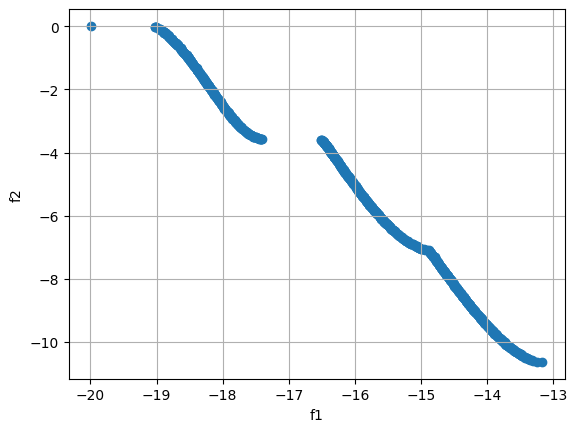

In [23]:
# Problem Definition
problem = {
    'cost_function': MOP4,
    'n_var': 3,
    'var_min': -5,
    'var_max': 5,
}

generations = 50
population_size = 100
crossover_r = 0.7
alpha = 0.1
mutation_r = 0.3
mu = 0.05
verbose = True

# Solve the Problem
# results = run(problem=problem)
# population = results['population']
# F = results['F']

# pf_costs = np.array([population[i]['cost'] for i in F[0]])
# plt.scatter(pf_costs[:,0], pf_costs[:,1])
# plt.grid()
# plt.xlabel('f1')
# plt.ylabel('f2')
# plt.show()

# Using Pymoo

In [24]:
!pip install pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.6 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=2a93d31b6aeaef4e0c25cf02cfcbab3c42c56b5bd161b7dd125f000b573b8623
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


In [36]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.rnsga3 import RNSGA3
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

In [26]:
# define problems
def MOP2(x):
    n = len(x)
    z1 = 1 - np.exp(-np.sum((x - 1/np.sqrt(n))**2))
    z2 = 1 - np.exp(-np.sum((x + 1/np.sqrt(n))**2))
    return np.array([z1, z2])

def MOP4(x):
    a = 0.8
    b = 3
    z1 = np.sum(-10 * np.exp(-0.2 * np.sqrt(x[:-1]**2 + x[1:]**2)))
    z2 = np.sum(np.abs(x)**a + 5 * np.sin(x)**b)
    return np.array([z1, z2])

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      2 |             - |             -
     2 |      200 |      2 |  0.0344088883 |         ideal
     3 |      300 |      3 |  0.4603518685 |         ideal
     4 |      400 |      9 |  0.4528148265 |         ideal
     5 |      500 |     14 |  0.1795479769 |         ideal
     6 |      600 |     18 |  0.1317539878 |         ideal
     7 |      700 |     26 |  0.0225201880 |         ideal
     8 |      800 |     36 |  0.0137999172 |         ideal
     9 |      900 |     43 |  0.0330185585 |         ideal
    10 |     1000 |     48 |  0.0219284548 |         ideal
    11 |     1100 |     60 |  0.0787651110 |         ideal
    12 |     1200 |     66 |  0.0118650478 |         ideal
    13 |     1300 |     71 |  0.0035585842 |             f
    14 |     1400 |     80 |  0.0394681584 |         ideal
    15 |     1500 |     80 |  0.0027816447 |         nadir
    16 |     1600 |     87 |  0.0014142265 |            

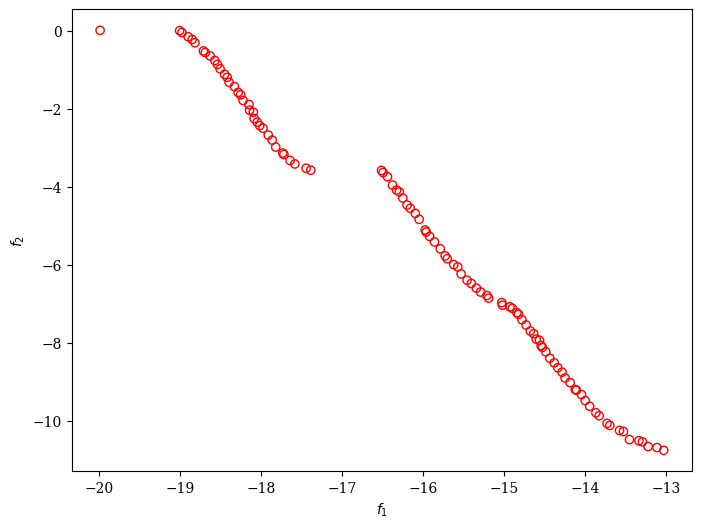

In [38]:
from pymoo.core.problem import (
    Problem, # for vectorisation
    ElementwiseProblem
)

class MOP4(Problem):
  def __init__(self, n_var=10):
    super(MOP4, self).__init__(n_var=n_var,
                               n_obj=2,
                               n_ieq_constr=0,
                               xl=-5.0,
                               xu=5.0)

  def _evaluate(self, x, out, *args, **kwargs):
    a = 0.8
    b = 3
    xi = x[:,:-1]
    xi1 = x[:, 1:]
    z1 = np.sum(-10 * np.exp(-0.2 * np.sqrt(xi**2 + xi1**2)), axis=1)
    z2 = np.sum(np.abs(x)**a + 5 * np.sin(x)**b, axis=1)
    out["F"] = np.column_stack([z1, z2])

# Define the multi-objective problem (MOP4)
problem = MOP4(n_var=3)

# Initialize the NSGA-II algorithm with a population size of 100
algorithm = NSGA2(pop_size=100)

# Execute the optimization process for 200 generations
res = minimize(problem,
               algorithm,
               ('n_gen', 50),
               seed=1,
               verbose=True)

# Visualize the resulting Pareto front
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()